# <font color="BlueViolet">Hybrid cosine method

In [2]:
# nb-cosine2.ipynb

In [3]:
import sys
#import os
#os.chdir('..')
import numpy as np
import pandas as pd
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance
from random import randint, seed
from settings import *
from user_func import toratings, prdf

In [4]:
print(f'System version: {sys.version}')
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version:  {np.__version__}')

System version: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.2.1
Numpy version:  1.26.4


In [5]:
start_time = time.time()

In [6]:
#pd.options.display.float_format = "{:,.2f}".format
DEBUG=False
seed(42)
pd.options.display.float_format = "{:,.2f}".format

In [7]:
def rmse(prediction, ground_truth):
    prediction = np.nan_to_num(prediction)[ground_truth.nonzero()].flatten()
    ground_truth = np.nan_to_num(ground_truth)[ground_truth.nonzero()].flatten()
    mse = mean_squared_error(prediction, ground_truth)
    return sqrt(mse)

In [8]:
# User-based mode
def naive_predict(top):
    top_similar_ratings = np.zeros((n_users, top, n_items))

    for i in range(n_users):
        # Нулевой элемент не подходит, т.к. на этом месте находится похожесть пользователя самого на себя
        top_sim_users = user_similarity[i].argsort()[1:top + 1]
        # берём только оценки из "обучающей" выборки 
        top_similar_ratings[i] = train_data_matrix[top_sim_users]

    pred = np.zeros((n_users, n_items))
    for i in range(n_users):
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    return pred

def naive_predict_item(top):
    top_similar_ratings = np.zeros((n_items, top, n_users))

    for i in range(n_items):
        top_sim_items = item_similarity[i].argsort()[1:top + 1]
        top_similar_ratings[i] = train_data_matrix.T[top_sim_items]
        
    pred = np.zeros((n_items, n_users))
    for i in range(n_items):
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred.T

In [9]:
# Реализация 2 с опорой на матрицу подобия 

def k_fract_predict(top):
    top_similar = np.zeros((n_users, top))
    
    for i in range(n_users):
        user_sim = user_similarity[i]
        top_sim_users = user_sim.argsort()[1:top+1]#[-top:]

        for j in range(top):
            top_similar[i, j] = top_sim_users[j]
            
    abs_sim = np.abs(user_similarity)
    pred = np.zeros((n_users, n_items))
    
    for i in range(n_users):
        indexes = top_similar[i].astype(int)
        numerator = user_similarity[i][indexes]
        product = numerator.dot(train_data_matrix[indexes])
        denominator = abs_sim[i][top_similar[i].astype(int)].sum()
        if denominator != 0:
            pred[i] = product / denominator
        else:
            pred[i] = 0
        
    return pred

def k_fract_predict_item(top):
    flag = True
    top_similar = np.zeros((n_items, top))
    for i in range(n_items):
        items_sim = item_similarity[i]
        top_sim_items = items_sim.argsort()[1:top + 1]
        for j in range(top):
            top_similar[i, j] = top_sim_items.T[j]
    abs_sim = np.abs(item_similarity)
    pred = np.zeros((n_items, n_users))
    for i in range(n_items):
        indexes = top_similar[i].astype(int)
        numerator = item_similarity[i][indexes]
        product = numerator.dot(train_data_matrix.T[indexes])
        denominator = abs_sim[i][indexes].sum()
        denominator = denominator if denominator != 0 else 1
        if denominator != 0:
            pred[i] = product / denominator
        else:
            pred[i] = 0
    return pred.T

In [10]:
# Рекомендации на основе средних оценок матрицы подобия
# Покупка является "оценкой".

def k_fract_mean_predict(top):
    top_similar = np.zeros((n_users, top))
    
    for i in range(n_users):
        user_sim = user_similarity[i]
        top_sim_users = user_sim.argsort()[1:top + 1]

        for j in range(top):
            top_similar[i, j] = top_sim_users[j]
            
    abs_sim = np.abs(user_similarity)
    pred = np.zeros((n_users, n_items))
    
    for i in range(n_users):
        indexes = top_similar[i].astype(int)
        numerator = user_similarity[i][indexes]
        
        tmp = np.array([x for x in train_data_matrix[i] if x > 0])
        if len(tmp) > 0:
            mean_rating = tmp.mean()
        else:
            mean_rating = 0
        del tmp
        diff_ratings = train_data_matrix[indexes] - train_data_matrix[indexes].mean()
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(int)].sum()
        
        if denominator != 0:
            pred[i] = mean_rating + numerator / denominator
        
    return pred

def k_fract_mean_predict_item(top):
    top_similar = np.zeros((n_items, top))
    
    for i in range(n_items):
        item_sim = item_similarity[i]
        top_sim_items = item_sim.argsort()[1:top + 1]
        
        for j in range(top):
            top_similar[i, j] = top_sim_items[j]
    
    abs_sim = np.abs(item_similarity)
    pred = np.zeros((n_items, n_users))
    
    for i in range(n_items):
        indexes = top_similar[i].astype(int)
        numerator = item_similarity[i][indexes]
        
        diff_ratings = train_data_matrix.T[indexes] - train_data_matrix.T[indexes].mean()
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(int)].sum()
        denominator = denominator if denominator != 0 else 1

        tmp = np.array([x for x in train_data_matrix.T[i] if x > 0])
        if len(tmp) > 0:
            mean_rating = tmp.mean()
        mean_rating = 0 if np.isnan(mean_rating) else mean_rating
        if denominator != 0:
            pred[i] = mean_rating + numerator / denominator
                
    return pred.T

In [39]:
K_TOP = 10

In [41]:
TOP_USERS=10 # Сколько top-пользователей выбирать среди тех, кто оценил данную категорию
TOP_ITEMS=5  # Сколько рекомендаций возвращать

def items_to_recommend(user):
    user_id = factor_u[user][1] # Идентификатор пользователя в dataset
    
    # Составим список купленных категорий:
    shop_list = set(df[df['userID'] == user_id]['ItemId'].values) # В виде номеров категорий
    ret = k_fract_mean_predict(K_TOP * 2)
    
    top_users = [] # Чьи рекомендации мы будем использовать 

    # Кто высоко оценивал категории целевого пользователя?
    for item in shop_list:
        rates = ret[:,item]
        data = np.argpartition(rates,-TOP_USERS)[-TOP_USERS:]
        top_users.extend(data)
        
    # Исключаем целевого пользователя из списка рекомендующих (если он там есть)
    if user in top_users:
        top_users.remove(user)

    # По всем пользователям выбираем top категории
    top_users = set(top_users)
    rates = [0] * n_items
    for x in top_users:
        rates += ret[x]
    data = np.argpartition(rates,-K_TOP)[-K_TOP:]
    data = list(data)

    # Убираем из рекомендаций то, что пользователь уже купил
    for x in shop_list:
        if x in data:
            data.remove(x)

    # Список рекомендованных категорий в виде массива названий
    return [factor_i[x][1] for x in data][:TOP_ITEMS]

In [43]:
# Эти данные не будут изменяться. Они нужны многократно в этом модуле

dataset = pd.read_pickle(ds_flt_file) # Полные данные после фильтрации
ds = pd.read_pickle(showcase_seg_file) # Сегментированная витрина
ds.reset_index('user_id', inplace=True)


Segment 0


,Method1,Method2,Method3
,,,
User-Based,0.51,0.82,0.82
Item-Based,0.94,0.95,0.06



Segment 1


,Method1,Method2,Method3
,,,
User-Based,0.51,0.90,0.90
Item-Based,0.96,0.96,0.06



Segment 2


,Method1,Method2,Method3
,,,
User-Based,0.60,0.75,0.75
Item-Based,0.89,0.90,0.11



Segment 3


,Method1,Method2,Method3
,,,
User-Based,0.30,0.96,0.96
Item-Based,0.98,0.98,0.08



Segment 4


,Method1,Method2,Method3
,,,
User-Based,0.74,0.64,0.64
Item-Based,0.90,0.90,0.09



Segment 5


,Method1,Method2,Method3
,,,
User-Based,0.65,0.59,0.59
Item-Based,0.86,0.86,0.12



Segment 6


,Method1,Method2,Method3
,,,
User-Based,0.49,0.94,0.94
Item-Based,0.95,0.96,0.09



Segment 7


,Method1,Method2,Method3
,,,
User-Based,0.62,0.74,0.74
Item-Based,0.91,0.92,0.08



Segment 8


,Method1,Method2,Method3
,,,
User-Based,0.62,0.77,0.77
Item-Based,0.92,0.92,0.08



Segment 9


,Method1,Method2,Method3
,,,
User-Based,0.58,0.79,0.79
Item-Based,0.92,0.92,0.09



Segment 10


,Method1,Method2,Method3
,,,
User-Based,0.75,0.44,0.44
Item-Based,0.91,0.91,0.11



Segment 11


,Method1,Method2,Method3
,,,
User-Based,0.64,0.71,0.71
Item-Based,0.91,0.91,0.09



Segment 12


,Method1,Method2,Method3
,,,
User-Based,0.41,0.92,0.92
Item-Based,0.98,0.98,0.06


CPU times: total: 11.7 s
Wall time: 11.6 s


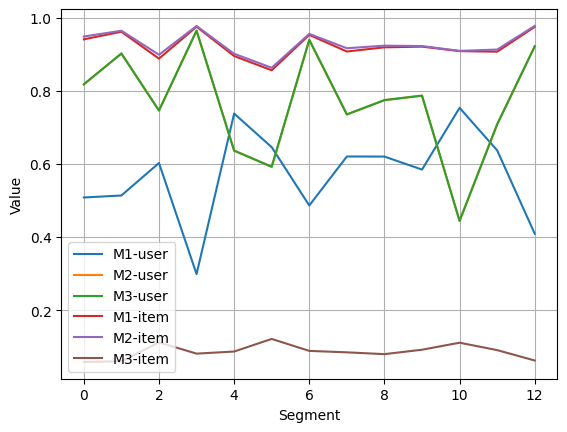

In [44]:
%%time
# Цикл оценки качества по сегментам

gr = [] # Собираем данные для графика
random.seed(42)
for seg in set(ds['Segment']):
    rank = pd.DataFrame()
    rank[''] = ['User-Based', 'Item-Based']
    print(f'\nSegment {seg}')
    df = ds[ds['Segment']==seg]
    #df.reset_index('user_id', inplace=True)
    df = dataset[(dataset['event_type'] == 'purchase') & (dataset['user_id'].isin(df['user_id']))][['user_id', 'category_code_level2', 'event_time']]
    df['rating'] = 1
    df.rename(columns = {'user_id': 'userID', 'category_code_level2': 'category', 'event_time': 'timestamp'}, inplace=True)
    df['UserId'] = pd.factorize(df['userID'])[0]   # UserId: 1..n_users
    df['ItemId'] = pd.factorize(df['category'])[0] # ItemId: 1..n_items

    factor_u = df[['UserId', 'userID']].drop_duplicates().values.tolist()   # [[0, 518638658], [1, 547064617],
    factor_i = df[['ItemId', 'category']].drop_duplicates().values.tolist() # [[0, 'diapers'], [1, 'toster'], 

    ratings_df = df.sort_values(by=['userID','timestamp'])[['UserId', 'ItemId', 'rating', 'timestamp']]

    n_users = ratings_df['UserId'].nunique()
    n_items = ratings_df['ItemId'].nunique()
    train_data, test_data = train_test_split(ratings_df, test_size=0.2)
    
    # Для определения качества предсказанных оценок воспользуемся мерой RMSE
    train_data_matrix = np.zeros((n_users, n_items))
    for line in train_data.itertuples():
        train_data_matrix[line[1] - 1, line[2] - 1] = line[3]
    
    test_data_matrix = np.zeros((n_users, n_items))
    for line in test_data.itertuples():
        test_data_matrix[line[1] - 1, line[2] - 1] = line[3]
        
    # считаем косинусное расстояние для пользователей и категорий 
    # (построчно и поколоночно).
    user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
    item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
    
    # user_similarity[i][j] — косинусное расстояние между i-ой строкой и j-ой строкой 
    # а item_similarity[i][j] — косинусное расстояние между i-ой и j-ой колонками.
    naive_pred = naive_predict(K_TOP)
    naive_pred_item = naive_predict_item(K_TOP)
    rank['Method1'] = [rmse(naive_pred, test_data_matrix), rmse(naive_pred_item, test_data_matrix)]

    k_predict = k_fract_mean_predict(K_TOP)
    k_predict_item = k_fract_predict_item(K_TOP)
    rank['Method2'] = [rmse(k_predict, test_data_matrix), rmse(k_predict_item, test_data_matrix)]
    
    k_predict = k_fract_mean_predict(K_TOP)
    k_predict_item = k_fract_mean_predict_item(K_TOP)
    rank['Method3'] = [rmse(k_predict, test_data_matrix), rmse(k_predict_item, test_data_matrix)]

    rank.set_index('', inplace=True)
    prdf(rank)

    gr.append([x for y in rank.values for x in y])
        
grdf = pd.DataFrame(gr, columns=['M1-user', 'M2-user', 'M3-user', 'M1-item', 'M2-item', 'M3-item'])
grdf.plot(xlabel='Segment', ylabel='Value', grid=True);

In [45]:
# Цикл выдачи рекомендаций по сегментам
random.seed(42)
for seg in set(ds['Segment']):
    df = ds[ds['Segment']==seg]
    df = dataset[(dataset['event_type'] == 'purchase') & (dataset['user_id'].isin(df['user_id']))][['user_id', 'category_code_level2', 'event_time']]
    df['rating'] = 1
    df.rename(columns = {'user_id': 'userID', 'category_code_level2': 'category', 'event_time': 'timestamp'}, inplace=True)
    df['UserId'] = pd.factorize(df['userID'])[0]   # UserId: 1..n_users
    df['ItemId'] = pd.factorize(df['category'])[0] # ItemId: 1..n_items
    ratings_df = df.sort_values(by=['userID','timestamp'])[['UserId', 'ItemId', 'rating', 'timestamp']]
    n_users = ratings_df['UserId'].nunique()
    n_items = ratings_df['ItemId'].nunique()
    train_data, test_data = train_test_split(ratings_df, test_size = 0.2)
    factor_u = df[['UserId', 'userID']].drop_duplicates().values.tolist()   # [[0, 518638658], [1, 547064617],
    factor_i = df[['ItemId', 'category']].drop_duplicates().values.tolist() # [[0, 'diapers'], [1, 'toster'], 
    
    # Для определения качества предсказанных оценок воспользуемся мерой RMSE
    train_data_matrix = np.zeros((n_users, n_items))
    for line in train_data.itertuples():
        train_data_matrix[line[1] - 1, line[2] - 1] = line[3]
    
    test_data_matrix = np.zeros((n_users, n_items))
    for line in test_data.itertuples():
        test_data_matrix[line[1] - 1, line[2] - 1] = line[3]
        
    # считаем косинусное расстояние для пользователей и категорий 
    # (построчно и поколоночно соотвественно).
    user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
    item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

    uid=560178807 #519382136, 513614418, 560178807
    if any(uid in sublist for sublist in factor_u):
        arr_u = np.array(factor_u)
        suser = np.where(arr_u == uid)[0][0]
        print(f'{suser} found in segment {seg}')
    else:
        suser = None
    print(f'\nСегмент: {seg}')
    for id in random.sample(range(0, n_users), 5):
        if suser:
            id = suser
            suser = None
        print(f'Пользователь: {factor_u[id][1]}')
        print(f'Рекомендовано: {items_to_recommend(id)}')
        print(f'Куплено: {set(dataset[(dataset["user_id"]==factor_u[id][1]) & (dataset["event_type"]=="purchase")]["category_code_level2"])}\n')
    print('*' * 80)


231 found in segment 0

Сегмент: 0
Пользователь: 560178807
Рекомендовано: ['faucet', 'juicer', 'carriage', 'subwoofer', 'monitor']
Куплено: {'notebook', 'headphone', 'microwave'}

Пользователь: 518869739
Рекомендовано: ['carriage', 'tv', 'desktop', 'notebook', 'juicer']
Куплено: {'water_heater', 'faucet'}

Пользователь: 517536523
Рекомендовано: ['kettle', 'carriage', 'hdd', 'water_heater', 'microwave']
Куплено: {'notebook', 'desktop'}

Пользователь: 513307654
Рекомендовано: ['shirt', 'toilet', 'microwave', 'kettle', 'faucet']
Куплено: {'headphone', 'desktop', 'monitor'}

Пользователь: 536169757
Рекомендовано: ['notebook', 'hdd', 'subwoofer', 'microwave', 'tv']
Куплено: {'juicer', 'carriage'}

********************************************************************************

Сегмент: 1
Пользователь: 546675374
Рекомендовано: ['trainer', 'video', 'tv', 'blender', 'compressor']
Куплено: {'vacuum', 'microphone', 'refrigerators'}

Пользователь: 514557046
Рекомендовано: ['faucet', 'moccasins',

In [46]:
grdf.index.name = 'Segment'

In [47]:
print('Метрики ранжирования (RMSE) для разных способов')
prdf(grdf.T)
print('M1 - Наивные рекомендации')
print('M2 - Рекомендации с учётом средних оценок похожих пользователей')
print('M3 - Рекомендации на основе средних оценок пользователей и матрицы “похожести”')
print('user - User-base коллаборативная фильтрация (основанная на похожести пользователей)')
print('item - Item-Based коллаборативная фильтрация (основанная на похожести категорий)')

Метрики ранжирования (RMSE) для разных способов


Segment,0,1,2,3,4,5,6,7,8,9,10,11,12
M1-user,0.51,0.51,0.60,0.30,0.74,0.65,0.49,0.62,0.62,0.58,0.75,0.64,0.41
M2-user,0.82,0.90,0.75,0.96,0.64,0.59,0.94,0.74,0.77,0.79,0.44,0.71,0.92
M3-user,0.82,0.90,0.75,0.96,0.64,0.59,0.94,0.74,0.77,0.79,0.44,0.71,0.92
M1-item,0.94,0.96,0.89,0.98,0.90,0.86,0.95,0.91,0.92,0.92,0.91,0.91,0.98
M2-item,0.95,0.96,0.90,0.98,0.90,0.86,0.96,0.92,0.92,0.92,0.91,0.91,0.98
M3-item,0.06,0.06,0.11,0.08,0.09,0.12,0.09,0.08,0.08,0.09,0.11,0.09,0.06


M1 - Наивные рекомендации
M2 - Рекомендации с учётом средних оценок похожих пользователей
M3 - Рекомендации на основе средних оценок пользователей и матрицы “похожести”
user - User-base коллаборативная фильтрация (основанная на похожести пользователей)
item - Item-Based коллаборативная фильтрация (основанная на похожести категорий)


In [49]:
for col in grdf.columns:
    print(col,grdf[col].mean())

M1-user 0.5707381696414425
M2-user 0.7671223412454696
M3-user 0.7671223412454696
M1-item 0.9240375391871728
M2-item 0.9288855094641
M3-item 0.08665353088883807


In [19]:
seconds=int(time.time() - start_time)
print("%d:%02d" % (seconds//60, seconds-60*(seconds//60),))

0:49
